In [38]:

import numpy as np
import astropy.units as u
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

npix = 512
oversample = 16
npsf = 200

wavelength = 633*u.nm

pupil_diam = 6.75*u.mm

dm_diam = 10.2*u.mm
dm_pupil_diam = 9.5*u.mm
dm_fill_factor = (dm_pupil_diam/dm_pupil_diam).decompose().value

lyot_pupil_diam = 9.5*u.mm
lyot_stop_diam = 8.6*u.mm
fl = 300*u.mm

um_per_lamD = (wavelength * fl/lyot_stop_diam).to(u.um)
psf_pixelscale = 3.76*u.um/u.pix
psf_pixelscale_lamD = (psf_pixelscale/um_per_lamD).value
lyot_stop_ratio = (lyot_stop_diam/lyot_pupil_diam).decompose().value

psf_pixelscale_lamD, um_per_lamD

(0.17027909426013688, <Quantity 22.08139535 um>)

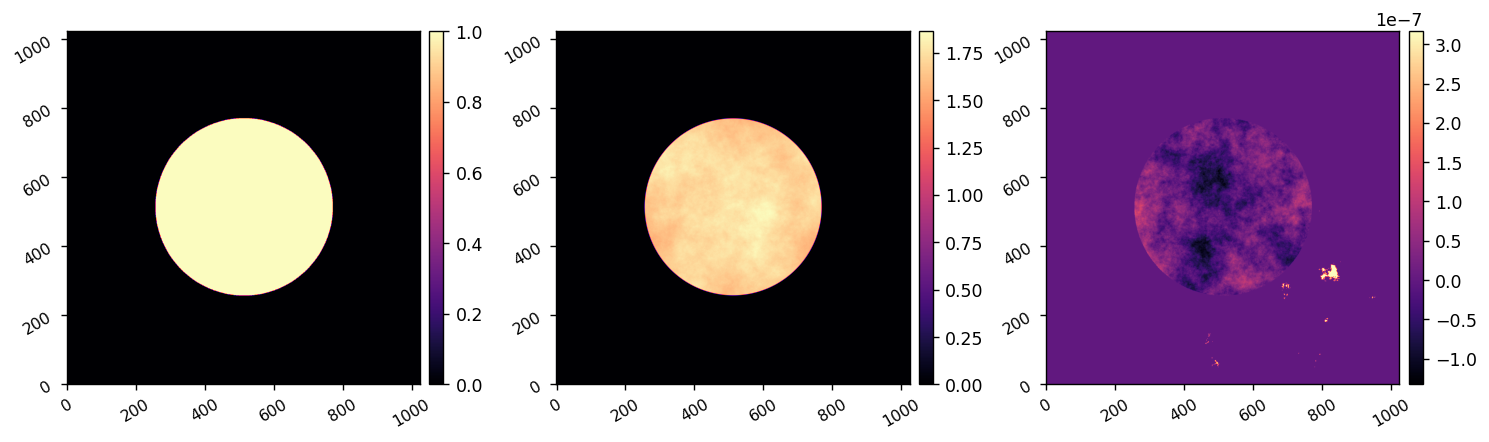

array(4.e-08)

In [39]:
reload(utils)
oversample = 2
wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=oversample,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=3)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow3(mask, wfe_amp, wfe_opd, )
lina.utils.rms(wfe_opd[mask])


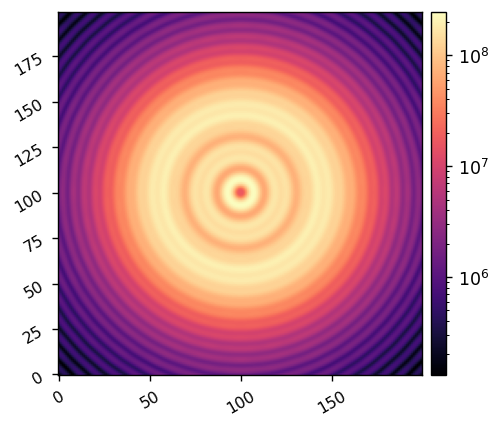

In [35]:
def get_scaled_coords(N, scale, center=True, shift=True):
    if center:
        cen = (N-1)/2.0
    else:
        cen = 0
        
    if shift:
        shiftfunc = xp.fft.fftshift
    else:
        shiftfunc = lambda x: x
    cy, cx = (shiftfunc(xp.indices((N,N))) - cen) * scale
    r = xp.sqrt(cy**2 + cx**2)
    return [cy, cx, r]

def get_fresnel_TF(dz, N, wavelength, fnum):
    '''
    Get the Fresnel transfer function for a shift dz from focus
    '''
    df = 1.0 / (N * wavelength * fnum)
    rp = get_scaled_coords(N,df, shift=False)[-1]
    return xp.exp(-1j*np.pi*dz*wavelength*(rp**2))

def mft_forward(pupil, psf_pixelscale_lamD):
    npix = pupil.shape[0]
    dx = 1.0 / npix
    Xs = (xp.arange(npix, dtype=float) - (npix / 2)) * dx

    du = psf_pixelscale_lamD
    Us = (xp.arange(npsf, dtype=float) - npsf / 2) * du

    xu = xp.outer(Us, Xs)
    vy = xp.outer(Xs, Us)

    My = xp.exp(-1j*2*np.pi*vy) 
    Mx = xp.exp(-1j*2*np.pi*xu) 

    return Mx@pupil@My

defocus = 2e-3*oversample**2
fnum = 100/8.6
tf = get_fresnel_TF(defocus, wfe.shape[0], wavelength.to_value(u.m), fnum)
image = xp.abs(mft_forward(tf*mask, psf_pixelscale_lamD*oversample))**2
imshow1(image, lognorm=True)

In [95]:
image.max()

array(268.26153665)

In [53]:
q

1.9575705096486888

In [15]:
Mx.shape

(512, 200)

In [7]:
xp.einsum

<function cupy.linalg._einsum.einsum(*operands, **kwargs)>

In [57]:
reload(utils)

<module 'scoobpsf.utils' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/utils.py'>

Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


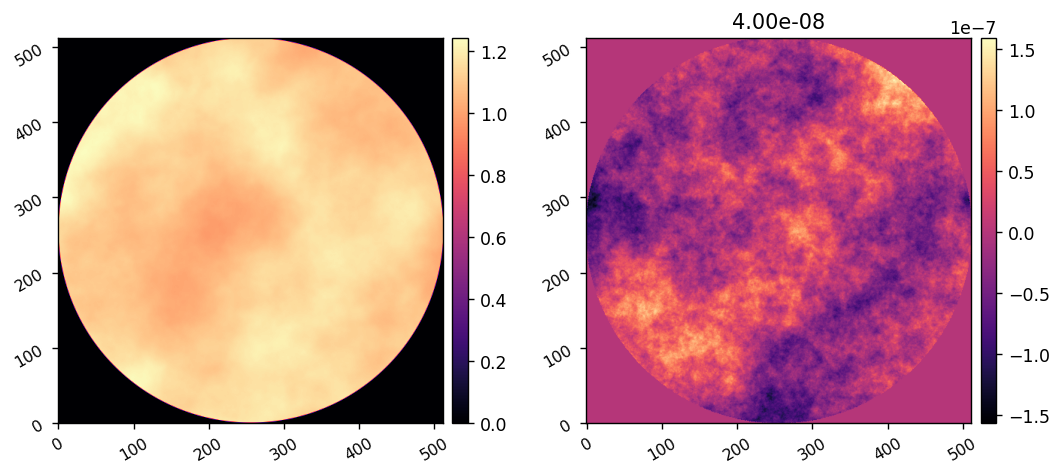

In [77]:
reload(cscoob)
reload(dm)

npix = 512
oversample = 16

model = cscoob.SCOOB(npix=npix, oversample=oversample, 
                     psf_pixelscale_lamD=psf_pixelscale_lamD)

wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
model.APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)

wfe, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_seed=123, amp_seed=1234,
                                opd_index=2.75, amp_index=4,
                                opd_rms=40*u.nm, amp_rms=0.05,
                                remove_modes=50)

wfe_amp = xp.abs(wfe)
wfe_opd = xp.angle(wfe)*wavelength.to_value(u.m)/2/np.pi
imshow2(wfe_amp, wfe_opd, '', f'{lina.utils.rms(wfe_opd[mask]):.2e}')

# model.WFE = wfe

VORTEX = cscoob.make_vortex_phase_mask(model.make_grid(which='fpm', polar=True), charge=6, 
                                    #    singularity=20*u.um, 
                                       focal_length=500*u.mm, pupil_diam=model.dm_pupil_diam, wavelength=632.8*u.nm)

lyot_stop = poppy.CircularAperture(radius=0.9*pupil_diam/2).get_transmission(wf)

# imshow3(model.APERTURE, model.LYOT, xp.angle(VORTEX), npix2=model.npix)

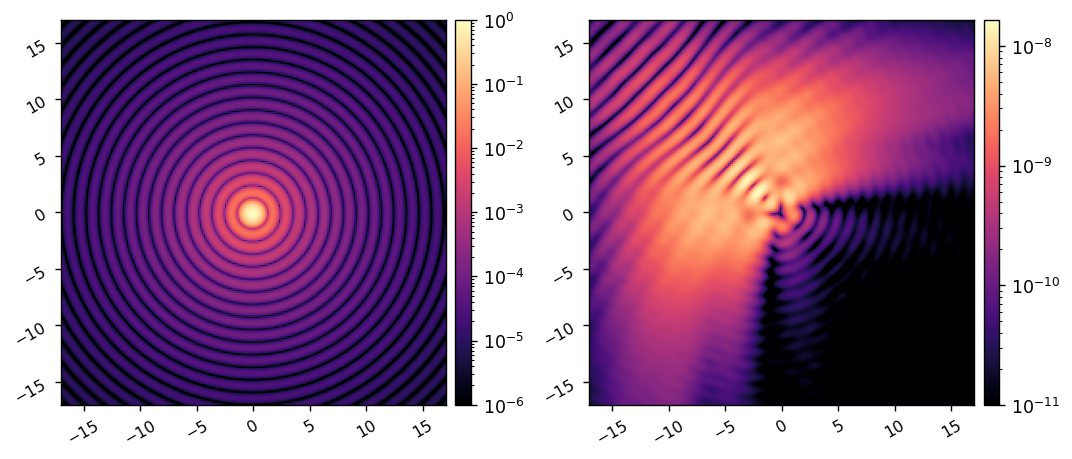

In [78]:
model.npsf = 200
model.FPM = None
model.LYOT = lyot_stop

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap()

model.Imax_ref = xp.max(ref_unocc_psf)
ni_psf = model.snap()

model.FPM = VORTEX

model.FIELDSTOP = None
# model.FIELDSTOP = model.focal_grid_pol[0]<15

ref_im = model.snap()

imshow2(ni_psf, ref_im, 
        pxscl=model.psf_pixelscale_lamD,
        vmin1=1e-6, vmin2=1e-11, lognorm=True)

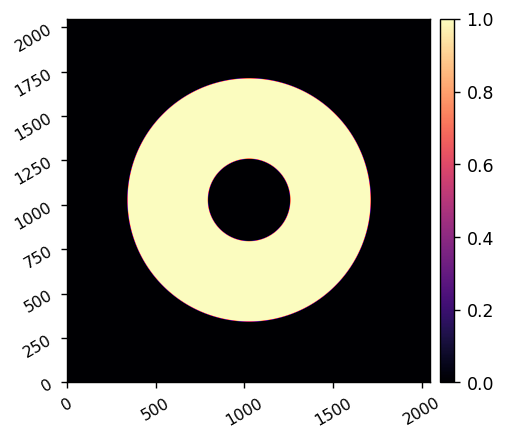

In [101]:
wf = poppy.FresnelWavefront(beam_radius=lyot_pupil_diam/2, npix=npix, oversample=5)
ref_lyot_stop = poppy.CircularAperture(radius=25.4*u.mm/2).get_transmission(wf) - poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(wf)
imshow1(ref_lyot_stop, npix=2048)

In [37]:
100/8.6 * 633e-9/2

3.6802325581395352e-06

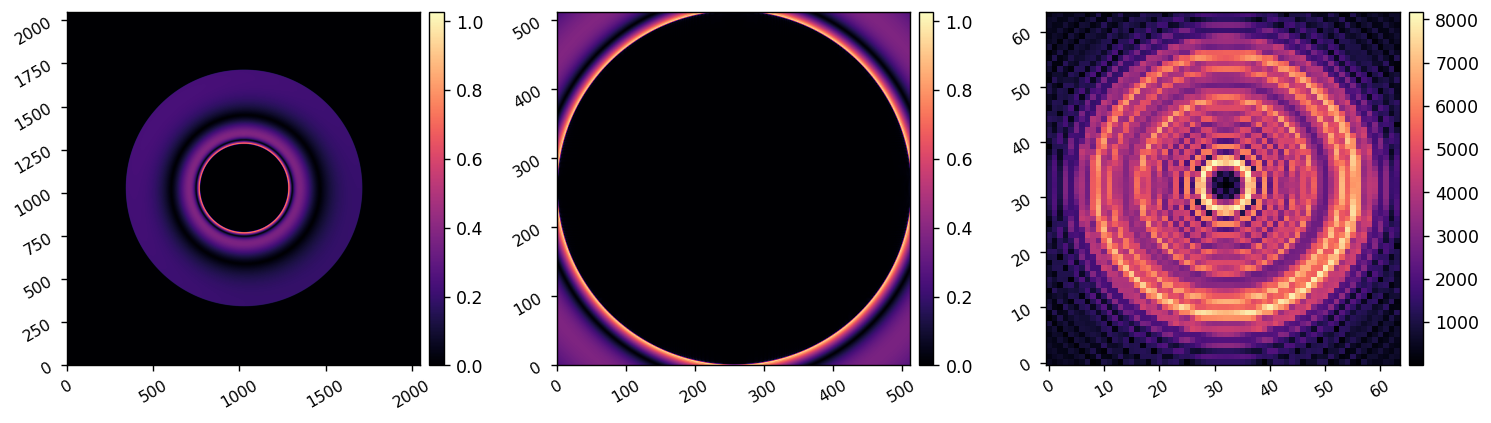

In [103]:
reload(cscoob)

model.use_llowfsc = True
model.llowfsc_fl = 100*u.mm
model.llowfsc_defocus = 0.9*u.mm

# model.FPM = None
# model.LYOT = xp.ones((model.npix,model.npix))

model.FPM = VORTEX
model.LYOT = ref_lyot_stop
wfs = model.propagate(return_all=True)

imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), xp.abs(wfs[-1]), 
        npix1=2048, npix2=npix,
        # lognorm2=True,
        )

In [13]:
!nvidia-smi

Tue Apr 23 10:42:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   35C    P0             65W /  300W |    9141MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
!kill 3409054

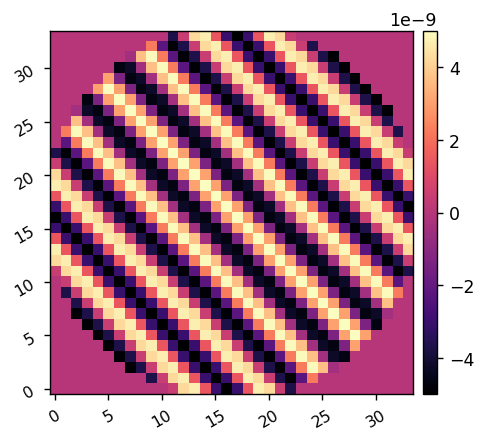

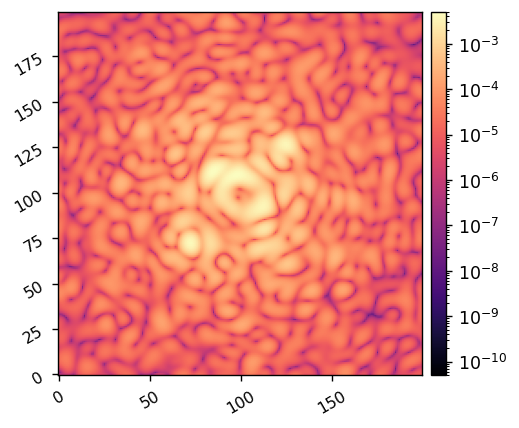

In [80]:
Nact = 34
xpp = xp.arange(-Nact//2, Nact//2) + 1/2
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-9
separation = 5
command = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/Nact)*model.dm_mask

imshow1(command)
model.set_dm(command)

im = model.snap()
imshow1(im, lognorm=True)

model.reset_dm()